In [1]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",80)

In [2]:
# Load the training set
df = pd.read_csv('training_data/loadTDS46.csv')
df = df.dropna(how='any',axis=0)
df.shape

(4554865, 39)

In [3]:
ohe_fields=['one_way','surface_type','street_type','hour','weekday','month']

# One-Hot encode a couple of variables
df_ohe = pd.get_dummies(df,columns=ohe_fields)

# Get the one-hot variable names
ohe_feature_names = pd.get_dummies(df[ohe_fields],columns=ohe_fields).columns.tolist()
df_ohe.head()

,join_key,Hopspot,Rain,aadt,accident_counts,at_exit,at_intersection,dew_point_temperature,dust,euclidean_length,extreme_air_temperature,population_density,proximity_to_billboard,proximity_to_major_road,proximity_to_nearest_exit,proximity_to_nearest_intersection,proximity_to_signal,road_orient_approx,segment_id,segment_length,sinuosity,sky_cover_layer,speed_limit,station_id,suf_dir,surface_width,target,temperature,timestamp,visibility,wind_speed,solar_azimuth,solar_elevation,one_way_B,one_way_FT,one_way_N,surface_type_DIRT,surface_type_IMPROVED,surface_type_OTHER,surface_type_PAVED,...,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,404370999992014-01-01T08:00:00+00:00,100,0.0,138359,1676,1,1,1,1,1945.436965,0,45.100697,10.008963,0.0,4.403371,0.0,6.584638,2.014171,67756,1945.448177,1.000006,0,60,40437099999,E,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,404370999992014-01-01T08:00:00+00:00,100,0.0,138359,1676,1,1,1,1,1945.436965,0,45.100697,10.008963,0.0,4.403371,0.0,6.584638,2.014171,67756,1945.448177,1.000006,0,60,40437099999,E,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,404370999992014-01-01T08:00:00+00:00,50,0.0,592709,26,0,1,1,1,636.911312,0,0.426397,658.584158,0.0,179.667331,0.0,19.942879,0.445400,122414,636.911312,1.000000,0,60,40437099999,S,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,404370999992014-01-01T08:00:00+00:00,50,0.0,592709,26,0,1,1,1,636.911312,0,0.426397,658.584158,0.0,179.667331,0.0,19.942879,0.445400,122414,636.911312,1.000000,0,60,40437099999,S,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,404370999992014-01-01T09:00:00+00:00,50,0.0,541869,543,0,1,1,1,4412.724810,0,0.710563,28.247391,0.0,1884.060204,0.0,2931.151993,2.082005,108401,4438.126882,1.005757,1,70,40437099999,W,60.0,1,16.9,2014-01-01 09:00:00+00:00,13046.5,3.6,180.975050,42.369043,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Use scikit-learn's StandardScaler

In [116]:
# Sinuosity is typically close to 1, even for moderately curvy roads. A high sinuosity means a longer road.
feature_transforms = {
    'sinuosity': np.log
}
for feature,transform in feature_transforms.items():
    df_ohe[feature] = transform(df_ohe[feature])

# Continuously valued features
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'Rain',
    'dust',
    'temperature',
    'visibility',
    'wind_speed',
    'proximity_to_billboard',
    'proximity_to_major_road',
    'proximity_to_signal',
    'proximity_to_nearest_intersection',
    'proximity_to_nearest_exit',
    'population_density',
    'Hopspot',
]
float_features = df_ohe.xs(float_feature_names,axis=1).values
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
print(scaler.mean_)
print (float_features.mean(axis=0))

df_ohe[float_feature_names] = float_scaled
with open('scalers_ee.pkl','wb') as fp:
    pickle.dump(scaler,fp)

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


[-9.92702861e-18 -2.76082504e-17  2.63711986e-18 -2.53556618e-17
 -1.20150189e+00  1.18079557e-17  8.44935231e-18  1.82784932e-17
  9.57671910e-20 -1.89754073e-17  1.12075644e-17  1.85889261e-17
 -3.45789514e-17 -1.09665499e-17 -2.61138045e-18 -1.26185522e-17
 -5.81184246e-19  1.22847198e-17  1.21427631e-17 -4.95132708e-18]
[-9.92702861e-18 -2.76082504e-17  2.63711986e-18 -2.53556618e-17
             nan  1.18079557e-17  8.44935231e-18  1.82784932e-17
  9.57671910e-20 -1.89754073e-17  1.12075644e-17  1.85889261e-17
 -3.45789514e-17 -1.09665499e-17 -2.61138045e-18 -1.26185522e-17
 -5.81184246e-19  1.22847198e-17  1.21427631e-17 -4.95132708e-18]


In [117]:
y = df['target'].values

binary_feature_names = [
    'extreme_air_temperature',
    'dew_point_temperature',
    'sky_cover_layer',
    'at_exit',
    'at_intersection',
]

df_ohe = df_ohe.xs(float_feature_names+binary_feature_names+ohe_feature_names,axis=1)

In [118]:
X = df_ohe.values
y = df['target'].values
feature_names = df_ohe.columns.tolist()

In [185]:
wrangler = {
    'scaler': scaler.mean_,
    'float_scaler_std': float_scaled,
    'float_feature_names': float_feature_names,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names,
    'feature_transforms': feature_transforms,
}
with open('wrangler_ee.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

# result of wrangler file

In [186]:
wrangler

{'scaler': array([-9.92702861e-18, -2.76082504e-17,  2.63711986e-18, -2.53556618e-17,
        -1.20150189e+00,  1.18079557e-17,  8.44935231e-18,  1.82784932e-17,
         9.57671910e-20, -1.89754073e-17,  1.12075644e-17,  1.85889261e-17,
        -3.45789514e-17, -1.09665499e-17, -2.61138045e-18, -1.26185522e-17,
        -5.81184246e-19,  1.22847198e-17,  1.21427631e-17, -4.95132708e-18]),
 'float_scaler_std': array([[ 0.21455446,  0.26407511, -0.16188289, ..., -0.78287998,
         -0.3925233 ,  0.49250211],
        [ 0.21455446,  0.26407511, -0.16188289, ..., -0.78287998,
         -0.3925233 ,  0.49250211],
        [-0.67694958,  0.26407511,  1.6593147 , ..., -0.67257754,
         -0.93315931, -1.79970052],
        ...,
        [-0.20094045, -1.88285298, -0.71647534, ...,  1.19367077,
         -0.89826681,  0.49250211],
        [ 1.08822842,  0.26407511,  0.32419469, ..., -0.71893378,
         -0.38134061,  0.49250211],
        [-0.69099752,  0.26407511, -0.263122  , ...,  9.84106895,

In [126]:
feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)
params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'subsample':0.8,    
    'eta':0.5
}

In [127]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=100,
    early_stopping_rounds=25
)

[0]	eval-auc:0.612318
Will train until eval-auc hasn't improved in 25 rounds.
[1]	eval-auc:0.625911
[2]	eval-auc:0.632624
[3]	eval-auc:0.63922
[4]	eval-auc:0.645109
[5]	eval-auc:0.645934
[6]	eval-auc:0.650907
[7]	eval-auc:0.653286
[8]	eval-auc:0.65476
[9]	eval-auc:0.655396
[10]	eval-auc:0.657836
[11]	eval-auc:0.659476
[12]	eval-auc:0.659882
[13]	eval-auc:0.661635
[14]	eval-auc:0.662136
[15]	eval-auc:0.662253
[16]	eval-auc:0.66299
[17]	eval-auc:0.664692
[18]	eval-auc:0.664918
[19]	eval-auc:0.665906
[20]	eval-auc:0.666491
[21]	eval-auc:0.66664
[22]	eval-auc:0.666973
[23]	eval-auc:0.667379
[24]	eval-auc:0.667914
[25]	eval-auc:0.668067
[26]	eval-auc:0.668178
[27]	eval-auc:0.668186
[28]	eval-auc:0.668506
[29]	eval-auc:0.668842
[30]	eval-auc:0.669844
[31]	eval-auc:0.669925
[32]	eval-auc:0.67063
[33]	eval-auc:0.670748
[34]	eval-auc:0.670887
[35]	eval-auc:0.670893
[36]	eval-auc:0.671191
[37]	eval-auc:0.67148
[38]	eval-auc:0.671446
[39]	eval-auc:0.671537
[40]	eval-auc:0.671714
[41]	eval-auc:0.6

In [128]:
print(fnames)

['accident_counts' 'speed_limit' 'aadt' 'surface_width' 'sinuosity'
 'euclidean_length' 'segment_length' 'road_orient_approx' 'Rain' 'dust'
 'temperature' 'visibility' 'wind_speed' 'proximity_to_billboard'
 'proximity_to_major_road' 'proximity_to_signal'
 'proximity_to_nearest_intersection' 'proximity_to_nearest_exit'
 'population_density' 'Hopspot' 'extreme_air_temperature'
 'dew_point_temperature' 'sky_cover_layer' 'at_exit' 'at_intersection'
 'one_way_B' 'one_way_FT' 'one_way_N' 'surface_type_DIRT'
 'surface_type_IMPROVED' 'surface_type_OTHER' 'surface_type_PAVED'
 'street_type_BRG' 'street_type_RA' 'street_type_RD' 'street_type_SKA'
 'street_type_SRV' 'street_type_ST' 'street_type_TRN' 'street_type_UPASS'
 'hour_0' 'hour_1' 'hour_2' 'hour_3' 'hour_4' 'hour_5' 'hour_6' 'hour_7'
 'hour_8' 'hour_9' 'hour_10' 'hour_11' 'hour_12' 'hour_13' 'hour_14'
 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'hour_19' 'hour_20' 'hour_21'
 'hour_22' 'hour_23' 'weekday_0' 'weekday_1' 'weekday_2' 'weekday_3'

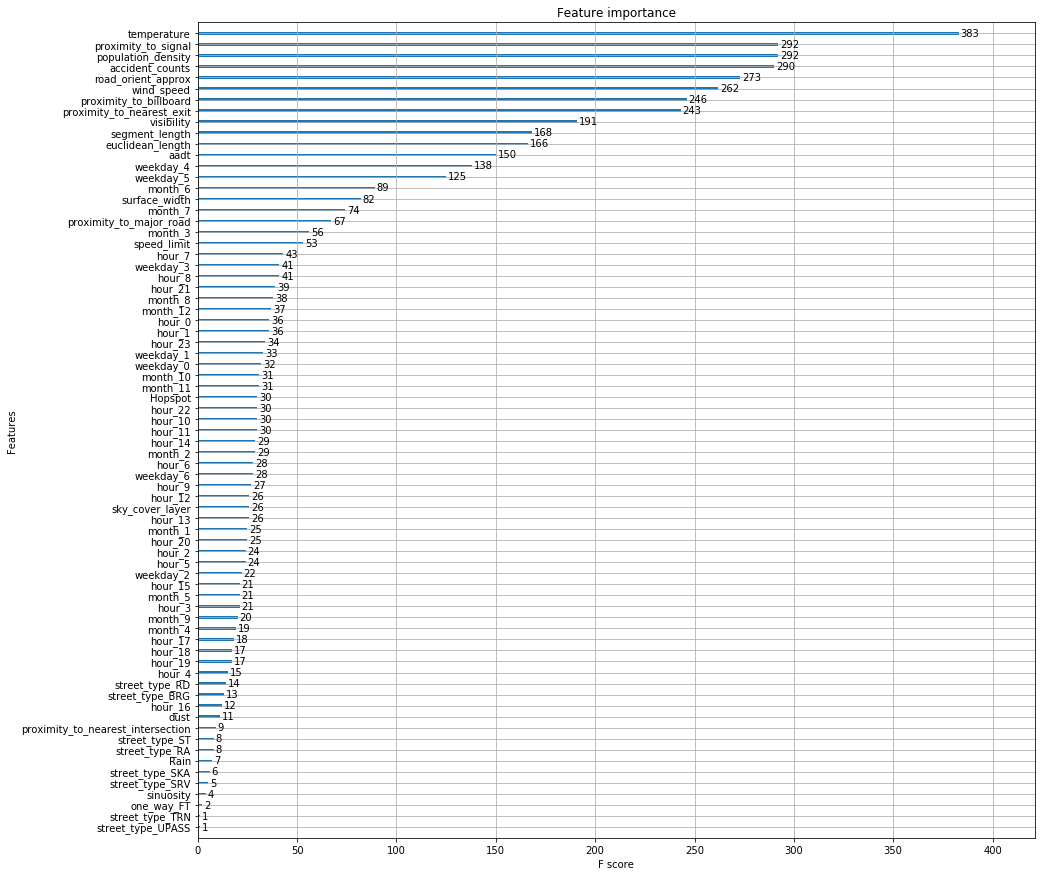

In [129]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [130]:
booster.save_model('new_000e.model')

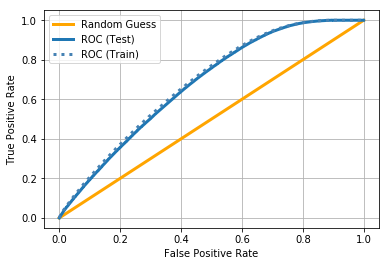

In [131]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

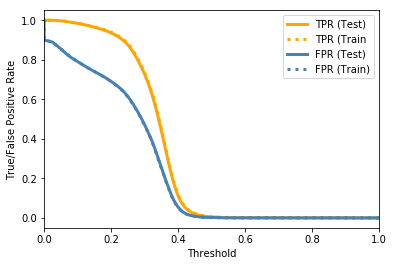

In [132]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

'3.0.3'

<Figure size 1080x1080 with 0 Axes>

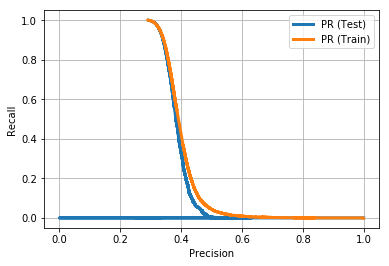

In [133]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest)
y_pred_train = booster.predict(dtrain)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

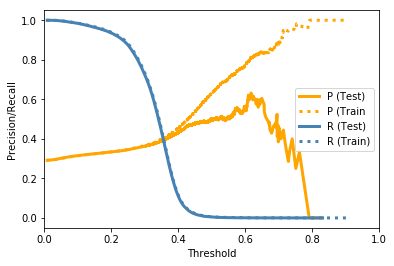

In [134]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

In [135]:
y_pred_test = booster.predict(dtest) > 0.19
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.19
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

Test Accuracy: 0.47227253467168107
Test F1: 0.491036018963367
Test Precision: 0.3318973906870771
Test Recall: 0.9433592319895863
Test AUC: 0.6761011797979086
Test AP: 0.386482601319618
Train Accuracy: 0.47307103663043515
Train F1: 0.4913520133581023
Train Precision: 0.33176658316177626
Train Recall: 0.9467597108853569
Train AUC: 0.684908698650078
Test AP: 0.39927305795933554


In [136]:
import pandas as pd
import geopandas as gpd
import time
import pickle
import os
import numpy as np
import xgboost
import pytz
import arcgis
#
#plotting
#'''
from IPython.display import HTML, display
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
#'''

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
mpl.rc('xtick', color='k')
mpl.rc('ytick', color='k')
%matplotlib inline
#'''
import datetime

In [187]:
with open('wrangler_ee.pkl','rb') as fp:
    wrangler = pickle.load(fp)

float_scaler_mean = wrangler['scaler']
float_scaler_std = wrangler['float_scaler_std']
float_feature_names = wrangler['float_feature_names']
ohe_fields = wrangler['ohe_fields']
feature_names = wrangler['feature_names'] 
booster = xgboost.Booster()
booster.load_model('new_000e.model')

In [138]:

project_gdb = r'D:\test_2014_2016\test_2014_2016\test_2014_2016.gdb'
collisions_path = os.path.join(project_gdb,'collisions_joined')
road_features_path = os.path.join(project_gdb,'static_features')

In [139]:
r_tz = pytz.timezone('Asia/Riyadh')

In [140]:
road_features = pd.read_csv('training_data/road_features.csv')

In [141]:
collisions =  pd.read_csv('training_data/collisions.csv')

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [142]:
tidx = pd.DatetimeIndex(collisions['timestamp']).floor('H')
tidx = tidx.tz_localize(r_tz,ambiguous='NaT')

In [143]:
#collisions['timestamp'] = pd.to_datetime(collisions.timestamp).map(utah_tz.localize)
collisions = collisions.set_index(tidx)
collisions.sort_index(inplace=True)

In [144]:
collisions['hour'] = collisions.index.hour
collisions['weekday'] = collisions.index.weekday
collisions['month'] = collisions.index.month

In [145]:
wdf = pd.read_csv('Riyadh_weather_2014-2019_grouped.csv')


In [146]:
wdf['timestamp'] = pd.to_datetime(wdf.timestamp).map(pytz.utc.localize)
wdf['timestamp'] = wdf['timestamp'].map(lambda x: x.astimezone(r_tz))

In [147]:
wdf = wdf.set_index('timestamp')

In [148]:
road_features.head(10)

,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,Join_Count_12,TARGET_FID_12,street_type,surface_type,suf_dir,one_way,speed_limit,surface_width,aadt,sinuosity,euclidean_length,segment_length,at_intersection,at_exit,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_nearest_exit,proximity_to_major_road,population_density,Hopspot,station_id,SHAPE,accident_counts
0,1,1,1,1,1,1,1,1,ST,PAVED,NaN,B,30.0,12.0,0.0,1.000000,64.890401,64.890401,1,0,0,2.185814,1053.887784,777.477505,0.0,883.018433,225.473390,64.854611,40,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0.0
1,2,2,1,2,1,2,1,2,NaN,DIRT,NaN,NaN,NaN,15.0,0.0,1.000000,101.499796,101.499796,1,0,0,2.911898,36121.459434,28517.262545,0.0,31532.527554,255.574594,0.000020,50,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0.0
2,3,3,1,3,1,3,1,3,ST,PAVED,NaN,B,30.0,20.0,0.0,1.000077,439.498395,439.532282,1,0,0,2.509810,96.769849,208.698728,0.0,290.061000,0.000000,26.663902,100,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",117.0
3,4,4,1,4,1,4,1,4,NaN,PAVED,NaN,NaN,NaN,10.0,0.0,1.000000,100.991057,100.991057,1,0,0,0.599869,4215.404517,2556.766267,0.0,2380.091967,0.000000,0.580848,40,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0.0
4,5,5,1,5,1,5,1,5,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000000,177.878340,177.878373,1,0,0,0.605544,538.720319,1204.747372,0.0,2064.392104,59.194919,84.861792,100,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0.0
5,6,6,1,6,1,6,1,6,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000003,297.831545,297.832558,1,0,0,1.499949,9148.218907,6872.365728,0.0,6820.935209,797.255968,20.768344,40,40448099999,"{'paths': [[[655297.4611999998, 2717691.933900...",12.0
6,7,7,1,7,1,7,1,7,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000094,229.489880,229.511369,1,0,0,0.601041,934.608023,138.044314,0.0,922.329552,74.113103,91.111845,100,40438099999,"{'paths': [[[680251.3321000002, 2733290.8082],...",4.0
7,8,8,1,8,1,8,1,8,SKA,PAVED,NaN,B,30.0,10.0,0.0,1.000000,42.998149,42.998149,1,0,0,2.209730,64.569174,1185.185381,0.0,2484.115698,46.276134,389.834595,100,40438099999,"{'paths': [[[674211.7929999996, 2724470.5998],...",0.0
8,9,9,1,9,1,9,1,9,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000000,87.043201,87.043201,1,0,0,0.614948,694.252642,509.225784,0.0,3114.109671,137.352996,108.723920,40,40438099999,"{'paths': [[[678928.574, 2740077.2250999995], ...",0.0
9,10,10,1,10,1,10,1,10,SKA,PAVED,NaN,B,30.0,10.0,430863.0,1.000007,149.888580,149.889562,1,0,0,1.758705,1001.581551,664.272690,0.0,3451.187229,95.839921,104.742725,100,40438099999,"{'paths': [[[671196.4494000003, 2724029.312200...",8.0


In [149]:
import geopandas as gpd
import json
import numpy as np
from shapely.geometry import LineString, Point, box, mapping
import ast
from pyproj import Proj

In [150]:
paths = road_features.SHAPE.map(lambda x: np.array(ast.literal_eval(x)['paths'][0]))

In [151]:
pathLineStrings = paths.map(LineString)

In [152]:
gdf = gpd.GeoDataFrame(road_features,geometry=pathLineStrings)
gdf.crs = {'init': 'epsg:32638'}
#gdf.crs = {'init': 'epsg:4326'}

In [153]:
gdf.head()


,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,Join_Count_12,TARGET_FID_12,street_type,surface_type,suf_dir,one_way,speed_limit,surface_width,aadt,sinuosity,euclidean_length,segment_length,at_intersection,at_exit,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_nearest_exit,proximity_to_major_road,population_density,Hopspot,station_id,SHAPE,accident_counts,geometry
0,1,1,1,1,1,1,1,1,ST,PAVED,NaN,B,30.0,12.0,0.0,1.000000,64.890401,64.890401,1,0,0,2.185814,1053.887784,777.477505,0.0,883.018433,225.473390,64.854611,40,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0.0,"LINESTRING (680670.8324999996 2735152.058, 680..."
1,2,2,1,2,1,2,1,2,NaN,DIRT,NaN,NaN,NaN,15.0,0.0,1.000000,101.499796,101.499796,1,0,0,2.911898,36121.459434,28517.262545,0.0,31532.527554,255.574594,0.000020,50,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0.0,LINESTRING (710241.2591000004 2771071.90750000...
2,3,3,1,3,1,3,1,3,ST,PAVED,NaN,B,30.0,20.0,0.0,1.000077,439.498395,439.532282,1,0,0,2.509810,96.769849,208.698728,0.0,290.061000,0.000000,26.663902,100,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",117.0,LINESTRING (668470.1953999996 2714535.56430000...
3,4,4,1,4,1,4,1,4,NaN,PAVED,NaN,NaN,NaN,10.0,0.0,1.000000,100.991057,100.991057,1,0,0,0.599869,4215.404517,2556.766267,0.0,2380.091967,0.000000,0.580848,40,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0.0,"LINESTRING (690822.8370000003 2735025.843, 690..."
4,5,5,1,5,1,5,1,5,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000000,177.878340,177.878373,1,0,0,0.605544,538.720319,1204.747372,0.0,2064.392104,59.194919,84.861792,100,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0.0,LINESTRING (685438.8331000004 2737051.80650000...


In [154]:
gdf = gdf.to_crs({'init': 'epsg:4326'})


In [155]:
x0 = 900714804574
x1 = -5120900
y0 = 900709927374
y1 = -9998100
SLC = box(x0,y0,x1,y1)

In [156]:
slc_df = gdf[gdf.intersects(SLC)]


In [157]:

slc_df.head()

,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,Join_Count_12,TARGET_FID_12,street_type,surface_type,suf_dir,one_way,speed_limit,surface_width,aadt,sinuosity,euclidean_length,segment_length,at_intersection,at_exit,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_nearest_exit,proximity_to_major_road,population_density,Hopspot,station_id,SHAPE,accident_counts,geometry
0,1,1,1,1,1,1,1,1,ST,PAVED,NaN,B,30.0,12.0,0.0,1.000000,64.890401,64.890401,1,0,0,2.185814,1053.887784,777.477505,0.0,883.018433,225.473390,64.854611,40,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0.0,LINESTRING (46.78620791303667 24.7202687876490...
1,2,2,1,2,1,2,1,2,NaN,DIRT,NaN,NaN,NaN,15.0,0.0,1.000000,101.499796,101.499796,1,0,0,2.911898,36121.459434,28517.262545,0.0,31532.527554,255.574594,0.000020,50,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0.0,LINESTRING (47.08384913010781 25.0406890366766...
2,3,3,1,3,1,3,1,3,ST,PAVED,NaN,B,30.0,20.0,0.0,1.000077,439.498395,439.532282,1,0,0,2.509810,96.769849,208.698728,0.0,290.061000,0.000000,26.663902,100,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",117.0,LINESTRING (46.66316186765538 24.5355368953859...
3,4,4,1,4,1,4,1,4,NaN,PAVED,NaN,NaN,NaN,10.0,0.0,1.000000,100.991057,100.991057,1,0,0,0.599869,4215.404517,2556.766267,0.0,2380.091967,0.000000,0.580848,40,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0.0,LINESTRING (46.88651720495255 24.7179008371508...
4,5,5,1,5,1,5,1,5,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000000,177.878340,177.878373,1,0,0,0.605544,538.720319,1204.747372,0.0,2064.392104,59.194919,84.861792,100,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0.0,LINESTRING (46.83357958623989 24.7368486838882...


C:\Users\maram\Anaconda3\envs\t\lib\site-packages\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\maram\Anaconda3\envs\t\lib\site-packages\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 4
  Warn('Warning: setting k to %d' % k_q, UserWarning)


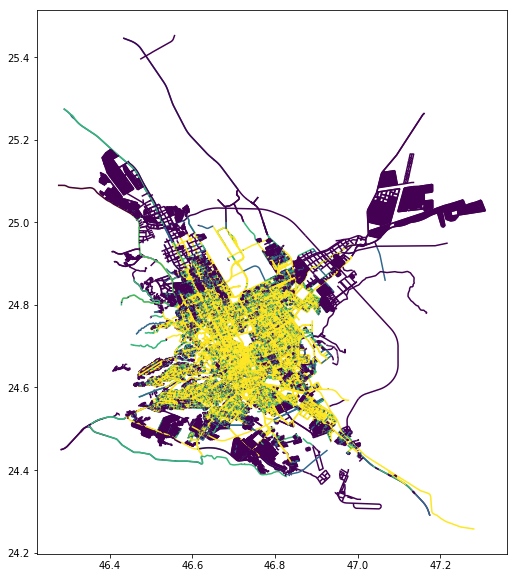

In [158]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))
#help(gdf.plot)
slc_df['scaled'] = slc_df['accident_counts']
slc_df.plot(ax=ax,column='scaled',scheme='quantiles')

In [159]:
slc_df.head()


,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,Join_Count_12,TARGET_FID_12,street_type,surface_type,suf_dir,one_way,speed_limit,surface_width,aadt,sinuosity,euclidean_length,segment_length,at_intersection,at_exit,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_nearest_exit,proximity_to_major_road,population_density,Hopspot,station_id,SHAPE,accident_counts,geometry,scaled
0,1,1,1,1,1,1,1,1,ST,PAVED,NaN,B,30.0,12.0,0.0,1.000000,64.890401,64.890401,1,0,0,2.185814,1053.887784,777.477505,0.0,883.018433,225.473390,64.854611,40,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0.0,LINESTRING (46.78620791303667 24.7202687876490...,0.0
1,2,2,1,2,1,2,1,2,NaN,DIRT,NaN,NaN,NaN,15.0,0.0,1.000000,101.499796,101.499796,1,0,0,2.911898,36121.459434,28517.262545,0.0,31532.527554,255.574594,0.000020,50,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0.0,LINESTRING (47.08384913010781 25.0406890366766...,0.0
2,3,3,1,3,1,3,1,3,ST,PAVED,NaN,B,30.0,20.0,0.0,1.000077,439.498395,439.532282,1,0,0,2.509810,96.769849,208.698728,0.0,290.061000,0.000000,26.663902,100,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",117.0,LINESTRING (46.66316186765538 24.5355368953859...,117.0
3,4,4,1,4,1,4,1,4,NaN,PAVED,NaN,NaN,NaN,10.0,0.0,1.000000,100.991057,100.991057,1,0,0,0.599869,4215.404517,2556.766267,0.0,2380.091967,0.000000,0.580848,40,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0.0,LINESTRING (46.88651720495255 24.7179008371508...,0.0
4,5,5,1,5,1,5,1,5,ST,PAVED,NaN,B,30.0,15.0,0.0,1.000000,177.878340,177.878373,1,0,0,0.605544,538.720319,1204.747372,0.0,2064.392104,59.194919,84.861792,100,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0.0,LINESTRING (46.83357958623989 24.7368486838882...,0.0


In [160]:
predTimest = pd.date_range('1/02/2014', periods=7*24, freq='H',tz='Asia/Riyadh')


In [161]:
predTimest


DatetimeIndex(['2014-01-02 00:00:00+03:00', '2014-01-02 01:00:00+03:00',
               '2014-01-02 02:00:00+03:00', '2014-01-02 03:00:00+03:00',
               '2014-01-02 04:00:00+03:00', '2014-01-02 05:00:00+03:00',
               '2014-01-02 06:00:00+03:00', '2014-01-02 07:00:00+03:00',
               '2014-01-02 08:00:00+03:00', '2014-01-02 09:00:00+03:00',
               ...
               '2014-01-08 14:00:00+03:00', '2014-01-08 15:00:00+03:00',
               '2014-01-08 16:00:00+03:00', '2014-01-08 17:00:00+03:00',
               '2014-01-08 18:00:00+03:00', '2014-01-08 19:00:00+03:00',
               '2014-01-08 20:00:00+03:00', '2014-01-08 21:00:00+03:00',
               '2014-01-08 22:00:00+03:00', '2014-01-08 23:00:00+03:00'],
              dtype='datetime64[ns, Asia/Riyadh]', length=168, freq='H')

In [162]:
prediction_time = predTimest[15]


In [163]:
test_df = slc_df.copy()


In [164]:
test_df['timestamp'] = prediction_time
test_df['station_id'] = slc_df.station_id.astype('int64')
test_df['hour'] = prediction_time.hour
test_df['weekday'] = prediction_time.weekday()
test_df['month'] = prediction_time.month

In [165]:
def add_join_key(df):
    df['join_key'] = df.station_id.map(int).map(str)+df.timestamp.map(datetime.datetime.isoformat)
    df = df.set_index('join_key')
    return df

In [166]:
weath_df = wdf.loc[prediction_time]


In [167]:
test_df = add_join_key(test_df)
weath_df = add_join_key(weath_df.reset_index())

In [168]:
test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))

In [169]:
test_df.columns


Index(['segment_id', 'OBJECTID', 'Join_Count', 'TARGET_FID', 'Join_Count_1',
       'TARGET_FID_1', 'Join_Count_12', 'TARGET_FID_12', 'street_type',
       'surface_type', 'suf_dir', 'one_way', 'speed_limit', 'surface_width',
       'aadt', 'sinuosity', 'euclidean_length', 'segment_length',
       'at_intersection', 'at_exit', 'near_billboard', 'road_orient_approx',
       'proximity_to_signal', 'proximity_to_billboard',
       'proximity_to_nearest_intersection', 'proximity_to_nearest_exit',
       'proximity_to_major_road', 'population_density', 'Hopspot',
       'station_id', 'SHAPE', 'accident_counts', 'geometry', 'scaled',
       'timestamp', 'hour', 'weekday', 'month', 'wind_speed', 'visibility',
       'temperature', 'Rain', 'sky_cover_layer', 'dew_point_temperature',
       'extreme_air_temperature', 'dust'],
      dtype='object')

# make_test_set(df,wrangler)

In [196]:
def make_test_set(df,wrangler):
    float_scaler_mean = wrangler['scaler']
    float_scaler_std = wrangler['float_scaler_std']
    float_feature_names = wrangler['float_feature_names']
    ohe_fields = wrangler['ohe_fields']
    feature_names = wrangler['feature_names']
    print(len(feature_names))
    df_ohe = pd.get_dummies(df,columns=ohe_fields)

    float_features = df.xs(float_feature_names,axis=1).values
    float_features = (float_features - float_scaler_mean) / float_scaler_std
    for i,fname in enumerate(float_feature_names):
        df_ohe[fname] = float_features[:,i]
        
    empty_features = list(set(feature_names) - set(df_ohe.columns.tolist()))
    
    #for f in empty_features:
    #    df_ohe[f] = 0
    
    df_ohe = df_ohe[feature_names]#.drop(columns=['SegID.1','geometry','SHAPE']+drop_columns,errors='ignore')
    
    #print(df_ohe.columns)
    #print(df_ohe.columns.tolist())
    X = df_ohe.values
    feature_names = df_ohe.columns.tolist()
    return X, feature_names

In [197]:
wrangler

{'scaler': array([-9.92702861e-18, -2.76082504e-17,  2.63711986e-18, -2.53556618e-17,
        -1.20150189e+00,  1.18079557e-17,  8.44935231e-18,  1.82784932e-17,
         9.57671910e-20, -1.89754073e-17,  1.12075644e-17,  1.85889261e-17,
        -3.45789514e-17, -1.09665499e-17, -2.61138045e-18, -1.26185522e-17,
        -5.81184246e-19,  1.22847198e-17,  1.21427631e-17, -4.95132708e-18]),
 'float_scaler_std': array([[ 0.21455446,  0.26407511, -0.16188289, ..., -0.78287998,
         -0.3925233 ,  0.49250211],
        [ 0.21455446,  0.26407511, -0.16188289, ..., -0.78287998,
         -0.3925233 ,  0.49250211],
        [-0.67694958,  0.26407511,  1.6593147 , ..., -0.67257754,
         -0.93315931, -1.79970052],
        ...,
        [-0.20094045, -1.88285298, -0.71647534, ...,  1.19367077,
         -0.89826681,  0.49250211],
        [ 1.08822842,  0.26407511,  0.32419469, ..., -0.71893378,
         -0.38134061,  0.49250211],
        [-0.69099752,  0.26407511, -0.263122  , ...,  9.84106895,

In [198]:
import matplotlib.colors as c
help(c.LinearSegmentedColormap.from_list)
cmap = c.LinearSegmentedColormap.from_list('traffic',['g','g','g','y','orange','r','darkred'])

Help on function from_list in module matplotlib.colors:

from_list(name, colors, N=256, gamma=1.0)
    Make a linear segmented colormap with *name* from a sequence
    of *colors* which evenly transitions from colors[0] at val=0
    to colors[-1] at val=1.  *N* is the number of rgb quantization
    levels.
    Alternatively, a list of (value, color) tuples can be given
    to divide the range unevenly.



In [199]:
'''
%matplotlib
fig,ax = plt.subplots()
for i,pt in enumerate(predTimest[:72]):
    test_df = slc_df.copy()
    test_df['timestamp'] = pt
    test_df['station_id'] = slc_df.station_id.astype('int64')
    test_df['hour'] = prediction_time.hour
    test_df['weekday'] = prediction_time.weekday()
    test_df['month'] = prediction_time.month
    
    weath_df = wdf.loc[pt]
    test_df = add_join_key(test_df)
    weath_df = add_join_key(weath_df.reset_index())
    
    test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))
    X,names = make_test_set(test_df,wrangler)
    xm = xgboost.DMatrix(X[:,:],feature_names=names)
    
    pred = booster.predict(xm)
    test_df['probability'] = np.minimum(pred,0.50)
    test_collisions = collisions[(pt - datetime.timedelta(seconds=0)).isoformat():(pt + datetime.timedelta(seconds=3600)).isoformat()]
    fig,ax = plt.subplots()
    
    fig.set_size_inches((15,15))
    test_df.plot(ax=ax,column='probability',cmap=cmap,linewidth=3,alpha=1)
    plt.gca().set_facecolor('k')
    #plt.imshow(np.array([[test_df.probability.min(),test_df.probability.max()]]),origin='lower')
    test_collisions.plot.scatter(x='DDLon',y='DDLat',ax=ax,s=100,marker='*',color='r',zorder=6e99)
    ax.set_xbound(lower=x0,upper=x1)
    ax.set_ybound(lower=y0,upper=y1)
    #plt.colorbar()
    plt.savefig('{}.png'.format(i))
   
'''

"\n%matplotlib\nfig,ax = plt.subplots()\nfor i,pt in enumerate(predTimest[:72]):\n    test_df = slc_df.copy()\n    test_df['timestamp'] = pt\n    test_df['station_id'] = slc_df.station_id.astype('int64')\n    test_df['hour'] = prediction_time.hour\n    test_df['weekday'] = prediction_time.weekday()\n    test_df['month'] = prediction_time.month\n    \n    weath_df = wdf.loc[pt]\n    test_df = add_join_key(test_df)\n    weath_df = add_join_key(weath_df.reset_index())\n    \n    test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))\n    X,names = make_test_set(test_df,wrangler)\n    xm = xgboost.DMatrix(X[:,:],feature_names=names)\n    \n    pred = booster.predict(xm)\n    test_df['probability'] = np.minimum(pred,0.50)\n    test_collisions = collisions[(pt - datetime.timedelta(seconds=0)).isoformat():(pt + datetime.timedelta(seconds=3600)).isoformat()]\n    fig,ax = plt.subplots()\n    \n    fig.set_size_inches((15,15))\n    test_df.plot(ax=ax,column='probability',cmap

# The error

In [200]:
X,names = make_test_set(test_df,wrangler)
print (X.shape)
print (X[0])

83


ValueError: operands could not be broadcast together with shapes (143097,20) (4554865,20) 